In [1]:
import os

In [2]:
os.chdir(r'D:\subFinder')

In [3]:
## In this script we will train supervised models
# library imports
import pandas as pd
import gensim
from Codes.Supervised_Trainer import run_end_to_end
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
import plotly.express as px

In [35]:

## read the data
# sup_data_path = r"Data/Supervised_Sequences/dbCAN-PUL_07-01-2022.xlsx"
new_path = r"D:\subFinder\Data\Supervised_Sequences\Table S1.xls"
data = pd.read_excel(new_path)
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()


## removing the catch all classes
## for example multiple substrates and others 
old_data = pd.read_csv('Data/Supervised_Sequences/pul_seq_low_high_substr_year_corrected.tsv', sep = "\t")

old_data["high_level_substr"] = old_data["high_level_substr"].str.strip()

bad_puls = old_data[old_data["high_level_substr"].isin(["multiple_substrates", "mono/di/trisaccharide", "-", "human milk oligosaccharide", 
                                            "glycoprotein", "plant polysaccharide", "cellobiose"])]["PULid"].values


data = data[~data["PUL ID"].isin(bad_puls)]

data = data[["PUL ID", "updated_substrate (09/01/2022)"]]
data = pd.merge(data, old_data[["PULid","sig_gene_seq"]], left_on = ["PUL ID"], right_on = ["PULid"], how = "left")
data.columns = ["PUL ID", "high_level_substr", "PULid", "sig_gene_seq"]

data = data[~data["PUL ID"].isin(bad_puls)]


In [36]:
## read the data
# sup_data_path = r"Data/Supervised_Sequences/dbCAN-PUL_07-01-2022.xlsx"
new_sup_data_with_nulls = pd.read_csv(r"D:\subFinder\Data\Supervised_Sequences\supervised_seq_with_null.tsv", sep = "\t", 
                                      header = None)
new_sup_data_with_nulls.columns = ["PUL ID", "sequence"]

In [37]:
data = pd.merge(data, new_sup_data_with_nulls, on = ["PUL ID"], how = "left")
data = data.drop(["sig_gene_seq"],1)
data.columns = ['PUL ID', 'high_level_substr', 'PULid', 'sig_gene_seq']

C:\Users\vedpi\AppData\Local\Temp\ipykernel_9812\282975859.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [38]:
data.to_csv(r"Data/Supervised_Sequences/updated_data_filtered.csv", index = False)

In [39]:
data["high_level_substr"].value_counts()

capsule polysaccharide synthesis      106
pectin                                 39
xylan                                  35
beta-glucan                            21
alginate                               21
host glycan                            19
cellulose                              16
starch                                 16
chitin                                 15
galactomannan                          15
glycosaminoglycan                      14
arabinan                               12
galactan                               10
alpha-mannan                            8
beta-mannan                             8
carrageenan                             8
xyloglucan                              7
fructan                                 7
arabinoxylan                            6
agarose                                 6
arabinogalactan                         5
capsule polysaccharide degradation      4
beta-galactooligosaccharide             4
glucomannan                       

In [4]:

# top_k = 10
K = 5
known_unknown = False


## Doc2Vec_DM model
model_dm =  gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models_10_12//doc2vec_dm") 
model_dbow = gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models_10_12//doc2vec_dbow") 
model_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//word2vec_cbow") 
model_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//word2vec_sg") 
model_fasttext_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//fasttext_sg") 
model_fasttext_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//fasttext_cbow") 


KeyboardInterrupt: 

In [9]:
overall_catch = []
for top_k in tqdm(range(2,16)):
    for featurizer in ["lstm_with_attention", "just_attention", "vanilla_lstm", "countvectorizer", "doc2vec_dbow", "doc2vec_dm", "word2vec_cbow", "word2vec_sg", "fasttext_sg",
                       "fasttext_cbow"]:
        print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)  
            
        elif featurizer == "lstm_with_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
        elif featurizer == "just_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        elif featurizer == "vanilla_lstm": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        else:
            pass
        
        overall_catch.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        
        plt.close('all')

  0%|          | 0/14 [00:00<?, ?it/s]

Currently running for featurizer lstm_with_attention with 2 number of classes.
Currently running for featurizer just_attention with 2 number of classes.
Currently running for featurizer vanilla_lstm with 2 number of classes.
Currently running for featurizer countvectorizer with 2 number of classes.
Currently running for featurizer doc2vec_dbow with 2 number of classes.
Currently running for featurizer doc2vec_dm with 2 number of classes.
Currently running for featurizer word2vec_cbow with 2 number of classes.
Currently running for featurizer word2vec_sg with 2 number of classes.
Currently running for featurizer fasttext_sg with 2 number of classes.
Currently running for featurizer fasttext_cbow with 2 number of classes.
Currently running for featurizer lstm_with_attention with 3 number of classes.
Currently running for featurizer just_attention with 3 number of classes.
Currently running for featurizer vanilla_lstm with 3 number of classes.
Currently running for featurizer countvectori

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 9 number of classes.
Currently running for featurizer doc2vec_dm with 9 number of classes.
Currently running for featurizer word2vec_cbow with 9 number of classes.
Currently running for featurizer word2vec_sg with 9 number of classes.
Currently running for featurizer fasttext_sg with 9 number of classes.
Currently running for featurizer fasttext_cbow with 9 number of classes.
Currently running for featurizer lstm_with_attention with 10 number of classes.
Currently running for featurizer just_attention with 10 number of classes.
Currently running for featurizer vanilla_lstm with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer countvectorizer with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer doc2vec_dbow with 10 number of classes.
Currently running for featurizer doc2vec_dm with 10 number of classes.
Currently running for featurizer word2vec_cbow with 10 number of classes.
Currently running for featurizer word2vec_sg with 10 number of classes.
Currently running for featurizer fasttext_sg with 10 number of classes.
Currently running for featurizer fasttext_cbow with 10 number of classes.
Currently running for featurizer lstm_with_attention with 11 number of classes.
Currently running for featurizer just_attention with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer vanilla_lstm with 11 number of classes.
Currently running for featurizer countvectorizer with 11 number of classes.
Currently running for featurizer doc2vec_dbow with 11 number of classes.
Currently running for featurizer doc2vec_dm with 11 number of classes.
Currently running for featurizer word2vec_cbow with 11 number of classes.
Currently running for featurizer word2vec_sg with 11 number of classes.
Currently running for featurizer fasttext_sg with 11 number of classes.
Currently running for featurizer fasttext_cbow with 11 number of classes.
Currently running for featurizer lstm_with_attention with 12 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer just_attention with 12 number of classes.
Currently running for featurizer vanilla_lstm with 12 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer countvectorizer with 12 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer doc2vec_dbow with 12 number of classes.
Currently running for featurizer doc2vec_dm with 12 number of classes.
Currently running for featurizer word2vec_cbow with 12 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer word2vec_sg with 12 number of classes.
Currently running for featurizer fasttext_sg with 12 number of classes.
Currently running for featurizer fasttext_cbow with 12 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer lstm_with_attention with 13 number of classes.
Currently running for featurizer just_attention with 13 number of classes.
Currently running for featurizer vanilla_lstm with 13 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer countvectorizer with 13 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1

Currently running for featurizer doc2vec_dbow with 13 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer doc2vec_dm with 13 number of classes.
Currently running for featurizer word2vec_cbow with 13 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_sg with 13 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer fasttext_sg with 13 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer fasttext_cbow with 13 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer lstm_with_attention with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer just_attention with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer vanilla_lstm with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer countvectorizer with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer doc2vec_dm with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_cbow with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_sg with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_sg with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_cbow with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer lstm_with_attention with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer just_attention with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer vanilla_lstm with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer countvectorizer with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dm with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer word2vec_cbow with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_sg with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_sg with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_cbow with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

In [10]:
overall_catch = pd.DataFrame(overall_catch)

In [11]:
overall_catch.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [12]:
overall_catch.head(10)

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,2,lstm_with_attention,0.993103,0.995238,0.013793,0.009524,0.988889,0.995238,0.991679
1,2,just_attention,0.986207,0.980952,0.016893,0.027766,0.984541,0.980952,0.981764
2,2,vanilla_lstm,0.986207,0.975000,0.027586,0.050000,0.991304,0.975000,0.981169
3,2,countvectorizer,0.993103,0.995238,0.013793,0.009524,0.988889,0.995238,0.991679
4,2,doc2vec_dbow,0.903448,0.846429,0.040213,0.066459,0.914024,0.846429,0.866599
5,2,doc2vec_dm,0.993103,0.995238,0.013793,0.009524,0.988889,0.995238,0.991679
6,2,word2vec_cbow,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
7,2,word2vec_sg,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
8,2,fasttext_sg,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
9,2,fasttext_cbow,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000


In [13]:
overall_catch.to_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup.csv", index = False)

In [14]:
keep_the_best = overall_catch.loc[overall_catch.groupby('num_substrates')['avg_classwise_acc'].idxmax()]

In [15]:
keep_the_best

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
6,2,word2vec_cbow,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
11,3,just_attention,0.972222,0.959921,0.035136,0.049187,0.963239,0.959921,0.960952
21,4,just_attention,0.955244,0.920357,0.033133,0.075099,0.948223,0.920357,0.919260
37,5,word2vec_sg,0.941414,0.912143,0.011152,0.025213,0.934166,0.912143,0.916241
41,6,just_attention,0.917177,0.887262,0.047069,0.060823,0.916077,0.887262,0.886452
59,7,fasttext_cbow,0.891101,0.840204,0.042013,0.055496,0.866911,0.840204,0.838203
69,8,fasttext_cbow,0.889899,0.852887,0.026815,0.037904,0.863402,0.852887,0.845943
79,9,fasttext_cbow,0.861283,0.810551,0.045091,0.058169,0.821851,0.810551,0.794874
82,10,vanilla_lstm,0.844699,0.774929,0.045598,0.073001,0.799777,0.774929,0.769170
90,11,lstm_with_attention,0.829563,0.764437,0.029498,0.033298,0.794837,0.764437,0.760923


In [16]:
keep_the_best["feature_method"].value_counts()

word2vec_sg            4
just_attention         3
fasttext_cbow          3
lstm_with_attention    2
word2vec_cbow          1
vanilla_lstm           1
Name: feature_method, dtype: int64

In [17]:
melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc', "avg_precision", "avg_f1_score"])

In [18]:
# melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc'])

In [19]:
melt_best.columns = ['num_substrates', 'metric_name', 'metric_value']

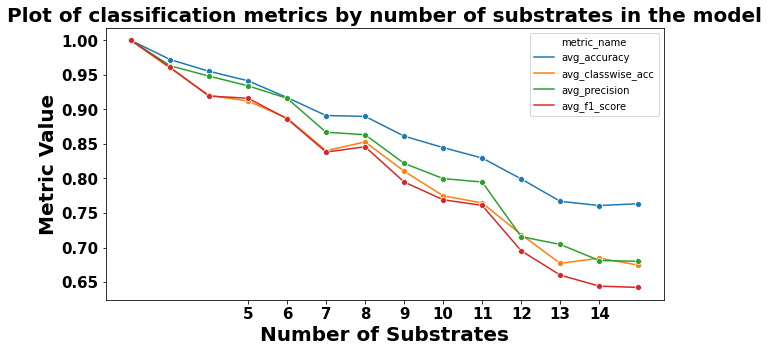

In [20]:
plt.figure(figsize = (10,5))
sns.lineplot(data=melt_best, x="num_substrates", y="metric_value", hue="metric_name",  marker="o")
plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [21]:
overall_catch.head(30)

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,2,lstm_with_attention,0.993103,0.995238,0.013793,0.009524,0.988889,0.995238,0.991679
1,2,just_attention,0.986207,0.980952,0.016893,0.027766,0.984541,0.980952,0.981764
2,2,vanilla_lstm,0.986207,0.975000,0.027586,0.050000,0.991304,0.975000,0.981169
3,2,countvectorizer,0.993103,0.995238,0.013793,0.009524,0.988889,0.995238,0.991679
4,2,doc2vec_dbow,0.903448,0.846429,0.040213,0.066459,0.914024,0.846429,0.866599
5,2,doc2vec_dm,0.993103,0.995238,0.013793,0.009524,0.988889,0.995238,0.991679
6,2,word2vec_cbow,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
7,2,word2vec_sg,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
8,2,fasttext_sg,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
9,2,fasttext_cbow,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000


In [22]:
# plt.figure(figsize = (20,10))
# sns.lineplot(data=overall_catch, x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
# plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
# plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
# plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
# plt.xticks(range(5,15), weight = "bold", fontsize = 15)
# plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
# plt.show()

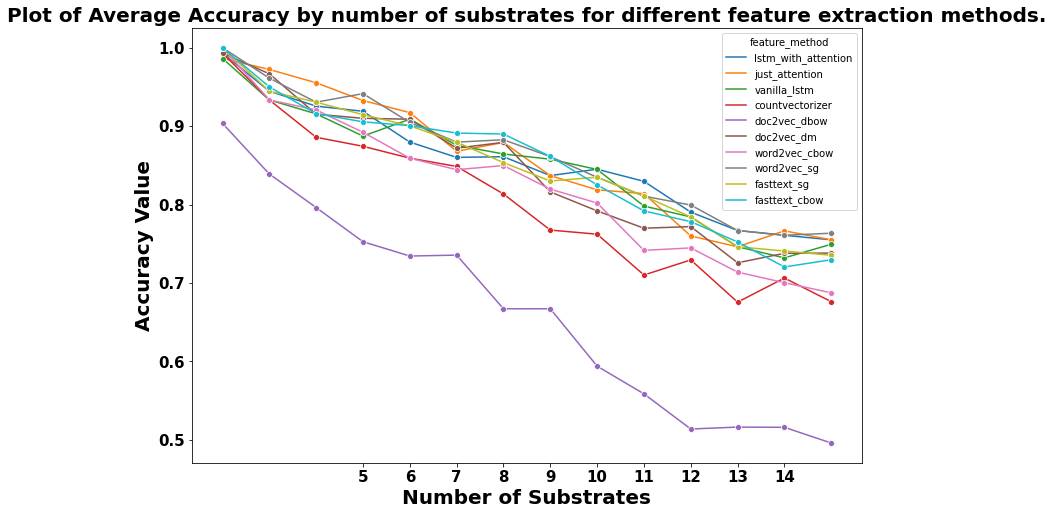

In [23]:
plt.figure(figsize = (12,8))
# filter_condn = [ "countvectorizer"]
sns.lineplot(data=overall_catch,  x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
plt.title("Plot of Average Accuracy by number of substrates for different feature extraction methods.", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Accuracy Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [24]:
# K = 3

In [25]:
# overall_catch_dl = []
# for top_k in tqdm(range(5,10)):
# # for top_k in tqdm(range(9,10)):    
#     for featurizer in ["lstm_with_attention", "just_attention", "vanilla_lstm"]:
#         print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
#         if featurizer == "countvectorizer":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        
#         elif featurizer == "doc2vec_dbow":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        
#         elif featurizer == "doc2vec_dm":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        
#         elif featurizer == "word2vec_cbow":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        
#         elif featurizer == "word2vec_sg":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
#         elif featurizer == "fasttext_sg":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        
#         elif featurizer == "fasttext_cbow":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)   
        
#         elif featurizer == "lstm_with_attention": 
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
#         elif featurizer == "just_attention": 
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
#         elif featurizer == "vanilla_lstm": 
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
#         else:
#             pass
        
#         overall_catch_dl.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
#                              overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        
#         plt.close('all')

In [26]:
# overall_catch_dl = pd.DataFrame(overall_catch_dl)

In [27]:
# overall_catch_dl.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
#                          "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [28]:
# overall_catch_dl.head(10)

In [29]:
# overall_catch_dl.to_csv(r"Data\Output\Experiments\results_by_k_deep_learners_new_sup_new_unsup.csv", index = False)

In [30]:
# keep_the_best_dl = overall_catch_dl.loc[overall_catch_dl.groupby('num_substrates')['avg_classwise_acc'].idxmax()]

In [31]:
# keep_the_best_dl

In [32]:
# melt_best_dl = keep_the_best_dl.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc', "avg_precision", "avg_f1_score"])

In [33]:
# melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc'])

In [34]:
# melt_best_dl.columns = ['num_substrates', 'metric_name', 'metric_value']

In [35]:
# melt_best_dl

In [36]:
# plt.figure(figsize = (15,7))
# sns.lineplot(data=melt_best_dl, x="num_substrates", y="metric_value", hue="metric_name",  marker="o")
# plt.title("Plot of classification metrics by number of substrates in the model for best deep learning model", fontsize = 20 ,weight = "bold")
# plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
# plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
# plt.xticks(range(5,10), weight = "bold", fontsize = 15)
# plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
# plt.show()

In [37]:
# overall_catch_dl.head()

In [38]:
# plt.figure(figsize = (20,10))
# sns.lineplot(data=overall_catch, x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
# plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
# plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
# plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
# plt.xticks(range(5,15), weight = "bold", fontsize = 15)
# plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
# plt.show()

In [39]:
# plt.figure(figsize = (12,8))
# # filter_condn = [ "countvectorizer"]
# sns.lineplot(data=overall_catch_dl,  x="num_substrates", y="avg_accurlacy", hue="feature_method",  marker="o")
# plt.title("Plot of Average Accuracy by number of substrates for different feature extraction methods.", fontsize = 20 ,weight = "bold")
# plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
# plt.ylabel("Accuracy Value", weight = "bold", fontsize = 20)
# plt.xticks(range(5,10), weight = "bold", fontsize = 15)
# plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
# plt.show()

In [4]:
import pandas as pd

In [5]:
methods_and_k = pd.read_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup.csv")

In [6]:
methods_and_k.head()

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,2,lstm_with_attention,0.993103,0.995238,0.013793,0.009524,0.988889,0.995238,0.991679
1,2,just_attention,0.986207,0.980952,0.016893,0.027766,0.984541,0.980952,0.981764
2,2,vanilla_lstm,0.986207,0.975000,0.027586,0.050000,0.991304,0.975000,0.981169
3,2,countvectorizer,0.993103,0.995238,0.013793,0.009524,0.988889,0.995238,0.991679
4,2,doc2vec_dbow,0.903448,0.846429,0.040213,0.066459,0.914024,0.846429,0.866599


In [ ]:
fig.update_xaxes(title_font_family="Arial")

In [14]:
fig = px.line(methods_and_k, x="num_substrates", y="avg_accuracy", color='feature_method', 
              markers=True, 
              title="PLot of Average Accuracy vs Number of substrate Categories", 
             labels={
                     "num_substrates": "Number of Substrate Categories",
                     "avg_accuracy": "Average Accuracy",
                     "feature_method": "Feature Extraction Method"
                 })
fig.update_traces(line=dict(width=4), marker=dict(size=8))
fig.write_html("results_by_k_new_sup_new_unsup.html")
fig.update_yaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_xaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_layout(
    font_family="Arial Black",
#     font_color="blue",
    title_font_family="Arial Black")
#     title_font_color="red",
#     legend_title_font_color="green"
fig.show()

In [45]:
keep_the_best = methods_and_k.loc[methods_and_k.groupby('num_substrates')['avg_accuracy'].idxmax()]

In [49]:
melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc', "avg_precision", "avg_f1_score"])

In [18]:
# melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc'])

In [50]:
melt_best.columns = ['num_substrates', 'metric_name', 'metric_value']

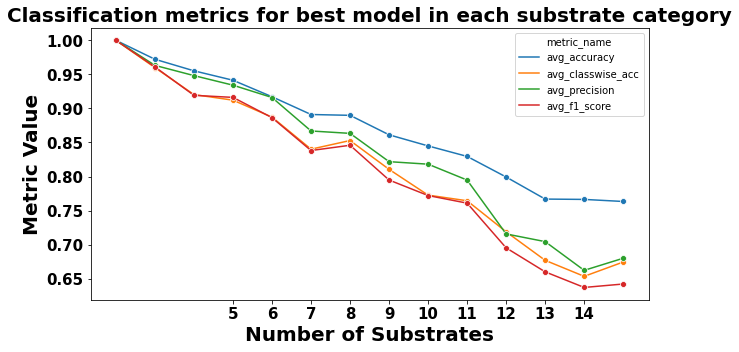

In [52]:
plt.figure(figsize = (10,5))
sns.lineplot(data=melt_best, x="num_substrates", y="metric_value", hue="metric_name",  marker="o")
plt.title("Classification metrics for best model in each substrate category", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [46]:
winners_podium = keep_the_best["feature_method"].value_counts().reset_index()

In [47]:
winners_podium.columns = ["Feature_Method", "Number_of_Times_Best"]

In [48]:
winners_podium

,Feature_Method,Number_of_Times_Best
0,just_attention,4
1,word2vec_sg,3
2,fasttext_cbow,3
3,lstm_with_attention,3
4,word2vec_cbow,1


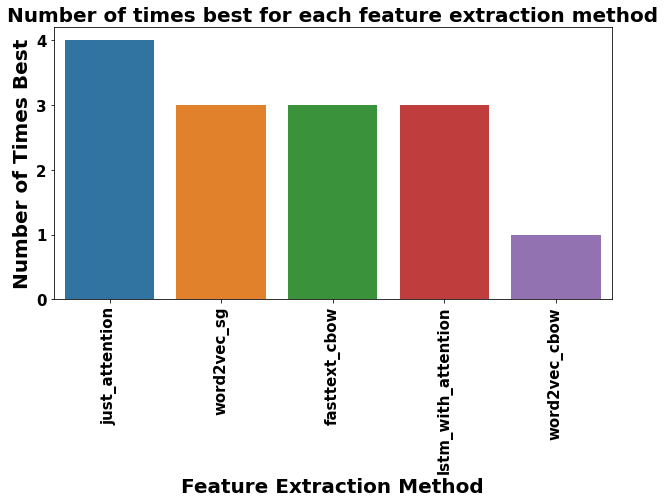

In [53]:
plt.figure(figsize = (10,5))
sns.barplot(data=winners_podium, x="Feature_Method", y="Number_of_Times_Best")
plt.title("Number of times best for each feature extraction method", fontsize = 20 ,weight = "bold")
plt.xlabel("Feature Extraction Method",  weight = "bold", fontsize = 20)
plt.ylabel("Number of Times Best", weight = "bold", fontsize = 20)
plt.yticks(range(0,5), weight = "bold", fontsize = 15)
plt.xticks(weight = "bold", fontsize = 15, rotation = 90)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [54]:
K = 5
known_unknown = True

In [55]:
overall_catch_word2vec_sg = []
for top_k in tqdm(range(2,17)):
    for featurizer in [ "word2vec_sg"]:
        print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)  
            
        elif featurizer == "lstm_with_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
        elif featurizer == "just_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        elif featurizer == "vanilla_lstm": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        else:
            pass
        
        overall_catch_word2vec_sg.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        
        plt.close('all')

  0%|          | 0/15 [00:00<?, ?it/s]

Currently running for featurizer word2vec_sg with 2 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 3 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 4 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 5 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 6 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 7 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 8 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 9 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 10 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 11 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 12 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 13 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 14 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 15 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 16 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

In [75]:
overall_catch_word2vec_sg = pd.read_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup_for_word2vec_sg_with_others.csv")

In [76]:
overall_catch_word2vec_sg = pd.DataFrame(overall_catch_word2vec_sg)

In [77]:
overall_catch_word2vec_sg.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [78]:
overall_catch_word2vec_sg["with_Others"] = "Yes"

In [59]:
# overall_catch_word2vec_sg.to_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup_for_word2vec_sg_with_others.csv", index = False)

In [65]:
K = 5
known_unknown = False

In [67]:
overall_catch_word2vec_sg_known = []
for top_k in tqdm(range(2,17)):
    for featurizer in [ "word2vec_sg"]:
        print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)  
            
        elif featurizer == "lstm_with_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
        elif featurizer == "just_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        elif featurizer == "vanilla_lstm": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        else:
            pass
        
        overall_catch_word2vec_sg_known.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        
        plt.close('all')

  0%|          | 0/15 [00:00<?, ?it/s]

Currently running for featurizer word2vec_sg with 2 number of classes.
Currently running for featurizer word2vec_sg with 3 number of classes.
Currently running for featurizer word2vec_sg with 4 number of classes.
Currently running for featurizer word2vec_sg with 5 number of classes.
Currently running for featurizer word2vec_sg with 6 number of classes.
Currently running for featurizer word2vec_sg with 7 number of classes.
Currently running for featurizer word2vec_sg with 8 number of classes.
Currently running for featurizer word2vec_sg with 9 number of classes.
Currently running for featurizer word2vec_sg with 10 number of classes.
Currently running for featurizer word2vec_sg with 11 number of classes.
Currently running for featurizer word2vec_sg with 12 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Currently running for featurizer word2vec_sg with 13 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Currently running for featurizer word2vec_sg with 14 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in lab

Currently running for featurizer word2vec_sg with 15 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Currently running for featurizer word2vec_sg with 16 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in lab

In [70]:
overall_catch_word2vec_sg_known = pd.DataFrame(overall_catch_word2vec_sg_known)

In [71]:
overall_catch_word2vec_sg_known.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [72]:
overall_catch_word2vec_sg_known["with_Others"] = "No"

In [79]:
stacked = pd.concat([overall_catch_word2vec_sg, overall_catch_word2vec_sg_known], ignore_index = True)

In [83]:
fig = px.line(stacked, x="num_substrates", y="avg_accuracy", color = "with_Others",
              markers=True, 
              title="PLot of Average Accuracy vs Number of substrate Categories for Word2Vec_SG method", 
             labels={
                     "num_substrates": "Number of Substrate Categories",
                     "avg_accuracy": "Average Accuracy",
                     "with_Others": "Others categories Present"
                 })
fig.update_traces(line=dict(width=4), marker=dict(size=8))
# fig.write_html("results_by_k_new_sup_new_unsup_for_word2vec_sg.html")
fig.update_yaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_xaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_layout(
    font_family="Arial Black",
#     font_color="blue",
    title_font_family="Arial Black")
#     title_font_color="red",
#     legend_title_font_color="green"
fig.show()